# GraphBrain

Graphbrain is an open-source AI NLP library for automated meaning extraction and text understanding. In comparison to conventional semantic parsers such as part-of-speech taggers and dependency parsers, Graphbrain can annotate natural language text at higher levels of detail using semantics.


Graphbrain is built around the concept of Semantic Hypergraph (SH). A hypergraph is a generalization of a graph in which an edge can join any number of vertices. SH is a graph data structure for representing natural language sentences as ordered, recursive hyperlinks, as shown below: 

<img src="http://drive.google.com/uc?export=view&id=18XvcgBH4AfxHxxh5_XEMZKEQXDElZNiZ" />

The Semantic Hypergraph data structure is used 1) as an intermediary between natural and formal languages, 2) as a knowledge model and 2) as a database. More details [here](https://graphbrain.net/manual/overview.html).

It is an advancement over  traditional graph-based network methods because 1) natural language is recursive, consisting of concepts constructed from other concepts as well as statements about statements and 2) natural language contains express n-ary relationships.




##Install libraries

In [ ]:
!pip install graphbrain
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


##Import libraries

In [ ]:
from graphbrain import *
from graphbrain.notebook import *
from graphbrain.parsers import *
from graphbrain.patterns import match_pattern
import os
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

##Using GraphBrain for NLP

We start by creating a parser object.

In [ ]:
parser = create_parser(lang='en')

Using language model: en_core_web_lg


Let's use a simple sentence to see how the parser works.

In [ ]:
parse_results = parser.parse('Einstein first published the theory of relativity in 1905')

The parser creates two main outputs. First, it builds the semantic hypergraph and returns this as "main_edge". Afterwards, it annotates every token of the given text.

In [ ]:
parse_results['parses'][0]['main_edge']

((first/M/en published/Pd.sox.<f-----/en) einstein/Cp.s/en (of/Br.ma/en (the/Md/en theory/Cc.s/en) relativity/Cc.s/en) (in/Tt/en 1905/C#/en))

In [ ]:
parse_results['parses'][0]['atom2word']

{first/M/en: ('first', 1),
 published/Pd.sox.<f-----/en: ('published', 2),
 einstein/Cp.s/en: ('Einstein', 0),
 of/Br.ma/en: ('of', 5),
 the/Md/en: ('the', 3),
 theory/Cc.s/en: ('theory', 4),
 relativity/Cc.s/en: ('relativity', 6),
 in/Tt/en: ('in', 7),
 1905/C#/en: ('1905', 8)}

###Hyperedge
Hyperedges are building units in hypergraph. It can be atomic or non-atomic. Every hyperedge belongs to one of six basic types. Non atomic hyperedges can hold a connection between two or more vertices of a hypergraph. 
In such cases, the first element of a hyperedge is a connector, followed by arguments that can be atomic or non-atomic sub-hyperedges.

<img src="http://drive.google.com/uc?export=view&id=1NoPjLXYFJhbo4_gKrs4rhZJd2GYkzKZC" width="700" />

In addition to these, it has subtypes in each of these main entity types. With this, we can annotate text in a greater detail.


<img src="http://drive.google.com/uc?export=view&id=1iXKXzwDg7gid85fqr1b_iY9qPzR80eFH" />



Let's explore some examples.

In [ ]:
sample_sentences = ["Today we learn semantic parsing with Graphbrain library","We can find patterns by traversing through hypergraphs"]

for sentence in sample_sentences:
  print(sentence)
  parse_results = parser.parse(sentence)
  show(parse_results['parses'][0]['main_edge'])
  print('\n')

Today we learn semantic parsing with Graphbrain library




We can find patterns by traversing through hypergraphs


### Create a hypergraph

In Graphbrain we can parse a text with multiple sentences to build a hypergraph, which then is a collection of hyperedges.

We have to create an empty hypergraph first.

In [ ]:
if(os.path.exists('example.db')):
  os.remove("example.db")
hg = hgraph('example.db')

We can write a function as follows to parse the text and add it to the hypergraph.

In [ ]:
def add_to_hg(hg,text):
  parse_results = parser.parse(text)
  for parse in parse_results['parses']:
      edge = parse['main_edge']
      show(edge, style='indented')
      hg.add(edge)

Let's use simpler sentences to get familiar with Graphbrain concepts.

In [ ]:
sentences = ['Mary likes to play violin.','Mary has a very old violin.',"Mary's brother is John.",
             'John likes football.','football is a popular outdoor sport','Mary watches football']

for s in sentences:
  add_to_hg(hg,s)

### Search a Hypergraph

Graphbrain provides a pattern language to query and match hyperedges in the hypergraph. This can be used to extract information from the text.

The basic wildcard is * and it matches any hyperedge.
We can use the below pattern to match any sentence with the connector "plays". "..." is for any following atomic or non-atomic hyperedges.

In [ ]:
results = list(hg.search('(likes/P ...)'))
for result in results:
  print(result)

(likes/Pd.so.|f--3s-/en john/Cp.s/en football/Cc.s/en)
(likes/Pd.sr.|f--3s-/en mary/Cp.s/en ((to/Mi/en play/P.o.-i-----/en) violin/Cc.s/en))


Also we can extract the text from the hyperedge.

In [ ]:
for result in results:
  print(result.label())

john likes football
mary likes to play violin


Similarly let's try to search usages of concept "football". Here we can have football as subject or the object. So we have to check both patterns.

In [ ]:
results = list(hg.search('(* * football/C)')) + list(hg.search('(* football/C *)'))
for result in results:
  print(result.label())

john likes football
mary watches football
football is a popular outdoor sport


Let's get all the concepts in the hypergraph with modifiers.

In [ ]:
results = list(hg.search('*/C'))
concepts_list = []
for result in results:
  concepts_list.append(result.label())
print(concepts_list)

['a very old violin', 'very old violin', 'violin', "mary 's brother", 'brother', 'john', 'a popular outdoor sport', 'popular outdoor sport', 'outdoor sport', 'sport', 'mary', 'football']


Here we get concepts which are sub-parts of other concepts. We can use the following function to filter repeating concepts.

In [ ]:
def check_substring(sub,s_list):
  s_list = list(set(s_list)-set([sub]))
  # print(s_list)
  for itr in s_list:
    if(sub in itr):
      if(sub+" 's" not in itr):#ignore any Possessive concepts
        return False
  return True


for concept in concepts_list:
  if(check_substring(concept,concepts_list)):
    print(concept)

a very old violin
mary 's brother
john
a popular outdoor sport
mary
football


### Degree of nodes in a hypergraph

In conventional graph theory, the degree of a node is the number of other nodes that it is directly connected to. 

This is a simple but generally useful measure of the centrality of a node in the graph. In hypergraphs, we can also have the same notion of degree, with the only difference that a single hyperedge can connect one entity to several others. 

In [ ]:
hg.degree('football/Cc.s/en')

3

In [ ]:
hg.degree('mary/Cp.s/en')

3

###Hyperedge attributes

We can add additional information to the concepts.

In [ ]:
hg.set_attribute('john/Cp.s/en', 'age', 7)
hg.set_attribute('john/Cp.s/en', 'height', '170cm')
hg.set_attribute('john/Cp.s/en', 'full name', 'John Doe')

True

In [ ]:
hg.get_str_attribute('john/Cp.s/en', 'full name')

'John Doe'

Patterns with variables for information extraction

In [ ]:
pattern = hedge('(likes/P PERSON/C PREFERENCE/C)')
results = list(hg.search('likes/P */C */C'))
for edge in results:
  print(match_pattern(edge, pattern))

[{'PERSON': john/Cp.s/en, 'PREFERENCE': football/Cc.s/en}]


###Triplet extraction

We can extract triplets from the hypergraph to show concepts and their relationships. Triplet is a group of three hyperedges with connector and two concepts.

In [ ]:
def triplet_extraction(hg):
  pattern = hedge('(PREDICATE/P CONCEPT1/C CONCEPT2/C)')
  results = list(hg.search('*/P */C */C'))
  triplets = []
  for edge in results:
    triplet = []
    match = match_pattern(edge, pattern)[0]
    
    for key in match.keys():
        triplet.append(match[key].label())
    triplets.append(triplet)
  return(triplets)


triplets = triplet_extraction(hg)
print(triplets)

[['has', 'mary', 'a very old violin'], ['is', "mary 's brother", 'john'], ['likes', 'john', 'football'], ['is', 'football', 'a popular outdoor sport'], ['watches', 'mary', 'football']]


###Visualising a hypergraph

In [ ]:
def draw_graph(triplets):
  edges = []
  edge_labels = {}

  for triplet in triplets:
    print(triplet)
    edges.append(triplet[1:])
    edge_labels[(triplet[1],triplet[2])]=triplet[0]
  print(edges)
  print(edge_labels)
  G = nx.Graph()
  G.add_edges_from(edges)
  pos = nx.spring_layout(G)
  plt.figure()
  nx.draw(
      G, pos, edge_color='black', width=1, linewidths=1,
      node_size=500, node_color='pink', alpha=0.8,
      labels={node: node for node in G.nodes()}
  )
  nx.draw_networkx_edge_labels(
      G, pos,
      edge_labels=edge_labels,
      font_color='red'
  )
  plt.axis('off')
  plt.margins(x=0.2)
  plt.show()

['has', 'mary', 'a very old violin']
['is', "mary 's brother", 'john']
['likes', 'john', 'football']
['is', 'football', 'a popular outdoor sport']
['watches', 'mary', 'football']
[['mary', 'a very old violin'], ["mary 's brother", 'john'], ['john', 'football'], ['football', 'a popular outdoor sport'], ['mary', 'football']]
{('mary', 'a very old violin'): 'has', ("mary 's brother", 'john'): 'is', ('john', 'football'): 'likes', ('football', 'a popular outdoor sport'): 'is', ('mary', 'football'): 'watches'}


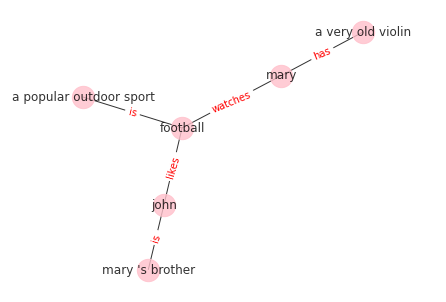

In [ ]:
draw_graph(triplets)



----------------------------------------

End of OptusU_AIN_Module_6c_Graphbrain.ipynb.